# 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 2. Settings

In [2]:

results_dir = "../results"
tickers = ["TSLA", "BND", "SPY"]

# 3. Load Processed Data (for actual values)

In [3]:
processed_data_dir = "../data/processed"
dfs = {}
for ticker in tickers:
    df = pd.read_csv(f"{processed_data_dir}/{ticker}_processed.csv", index_col=0, parse_dates=True)
    dfs[ticker] = df

# 4. Plot Forecast vs Actual for each ticker

Plotting forecast vs actual for TSLA...


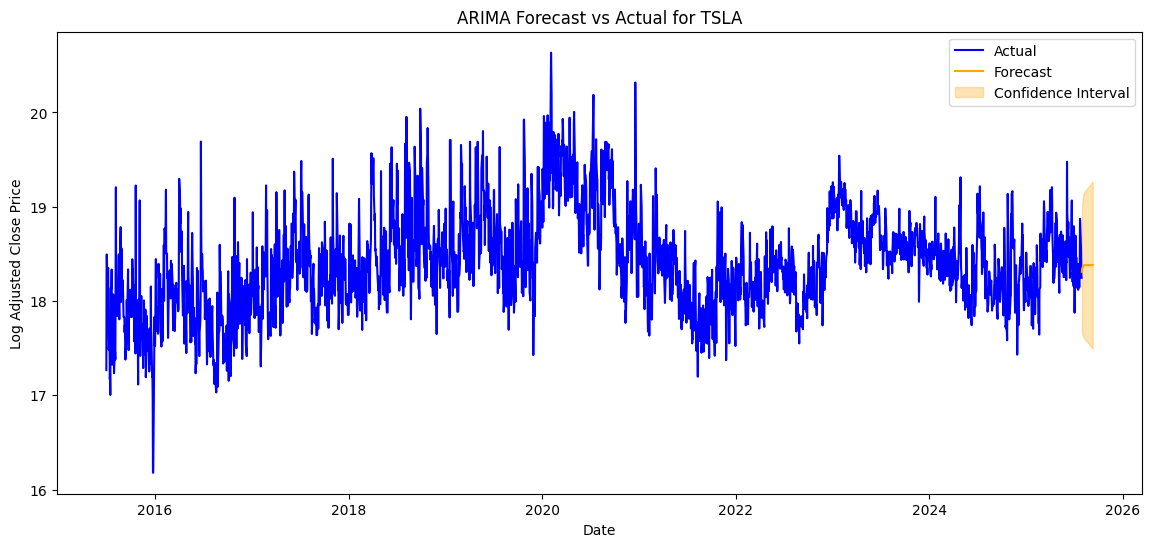

Plotting forecast vs actual for BND...


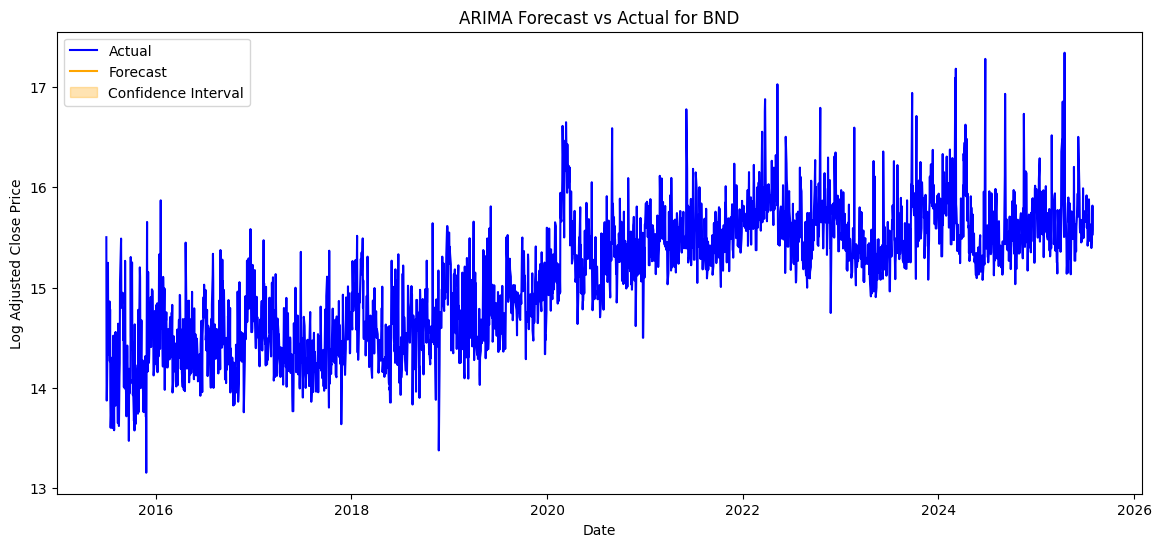

Plotting forecast vs actual for SPY...


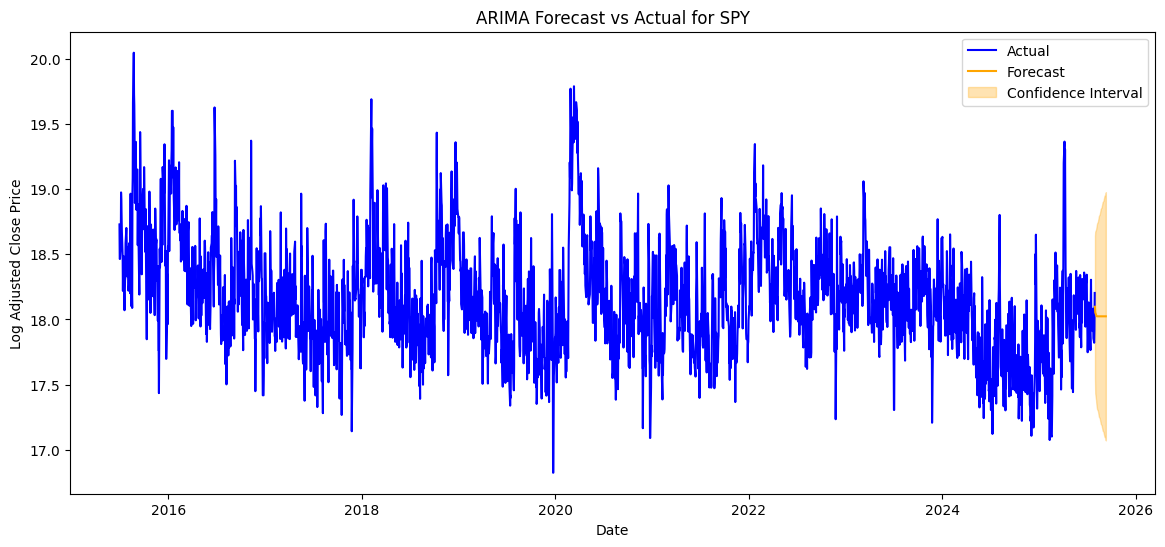

In [4]:
for ticker in tickers:
    print(f"Plotting forecast vs actual for {ticker}...")
    forecast_df = pd.read_csv(f"{results_dir}/forecast_arima_{ticker}.csv", index_col=0, parse_dates=True)
    actual_df = dfs[ticker]
    
    plt.figure(figsize=(14,6))
    plt.plot(actual_df.index, actual_df['log_adjclose'], label="Actual", color='blue')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label="Forecast", color='orange')
    plt.fill_between(forecast_df.index, 
                     forecast_df['Lower_CI'], forecast_df['Upper_CI'], 
                     color='orange', alpha=0.3, label="Confidence Interval")
    plt.title(f"ARIMA Forecast vs Actual for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Log Adjusted Close Price")
    plt.legend()
    plt.show()